In [1]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
from data_storage import create_connection
from stockstats import StockDataFrame
from risk_metrics import Risk_Metrics
import matplotlib.pyplot as plt
import os

In [2]:
connection = create_connection("../database/crypto_billionairs.db")

In [3]:
table_names = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", connection)
table_names_list = table_names['name'].tolist()
filtered_table_names = [name for name in table_names_list if "1min_complete_history_long_short_rsi" in name and "equity_curve" not in name]

In [4]:
class Momentum_RSI_long_short(Strategy):
   
    
    def init(self):
        # compute the rsi and stochastic oscillator with stockstats and return the buy signal of the current row
        
        self.buy_init = self.I(init_buy_signal, self.data.df)
        self.close_buy_init = self.I(init_close_long_signal, self.data.df)
        self.short_init = self.I(init_short_signal, self.data.df)
        self.data.df.drop(self.data.df.columns.difference(['Open', 'High', 'Low', 'Close', "Volume"]), 1, inplace=True)
        
       
    
    def next(self):
        
        if self.buy_init[-1] == 1 and self.position.is_long is False:
            self.position.close()
            self.buy()
            
        elif self.close_buy_init[-1] == 2 and self.position.is_long:
             self.position.close()
             
        elif self.short_init[-1] == -1 and self.position.is_short is False:
            self.position.close()
            self.sell()

In [5]:
def init_buy_signal(trash):
    return df_mkt_cap['buy_indicator']

def init_short_signal(trash):
    return df_mkt_cap['short_indicator']

def init_close_long_signal(df):
    return df_mkt_cap['close_indicator']

In [6]:
for table in filtered_table_names:
    
    global df_mkt_cap
    
    #determine which crypto reached a 1 billion market cap and when
    df = pd.read_sql_query(f"select * from {table}", connection)
    df_tmp = df.groupby(['year', 'month', 'day']).agg({'open' : 'mean', 'volume': 'sum'})
    df_tmp["market_cap"] = df_tmp["open"] * df_tmp["volume"]
    df_mkt_cap = pd.merge(df, df_tmp, how= 'inner', on =['year', 'month', 'day'])
    
    #print(df_mkt_cap["market_cap"].head())
    
    
    #take 4 billions because this is round about the market cap of the top 40 and has been longer than 1 month above
    if len(df_mkt_cap.index[df_mkt_cap["market_cap"] > 300000000]) > 0 and len(df_mkt_cap) > 2000000:
        
        index_market_cap_limit = df_mkt_cap.index[df_mkt_cap["market_cap"] > 300000000][0]
        print(index_market_cap_limit, table)
        
        df_mkt_cap = df_mkt_cap.iloc[index_market_cap_limit:]
        #print(df_mkt_cap.head())
        df_backtesting = pd.DataFrame()
        df_backtesting[['Open', 'High', 'Low', 'Close', "Volume"]] = df_mkt_cap[['open_x', 'high', 'low', 'close', 'volume_x']]
    
        bt = Backtest(df_backtesting, Momentum_RSI_long_short, cash=100_000, commission=.001)
        stats = bt.run()
    
        equity_curve = pd.DataFrame(stats["_equity_curve"])
        equity_curve.to_sql(f"equity_curve_{table}", connection, if_exists="replace")
            
    
    
    
    

13878 BCH_1min_complete_history_long_short_rsi


<ipython-input-6-10f96a4f8a34>:25: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df_backtesting, Momentum_RSI_long_short, cash=100_000, commission=.001)


797671 BTC_1min_complete_history_long_short_rsi
243441 EOS_1min_complete_history_long_short_rsi
1989914 ETC_1min_complete_history_long_short_rsi
235805 ETH_1min_complete_history_long_short_rsi
269496 LTC_1min_complete_history_long_short_rsi


KeyError: 'year'

In [8]:
table_names = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", connection)
table_names_list = table_names['name'].tolist()
filtered_table_names = [name for name in table_names_list if "equity_curve" in name]
filtered_table_names

['equity_curve_BCH_1min_complete_history_long_short_rsi',
 'equity_curve_BTC_1min_complete_history_long_short_rsi',
 'equity_curve_EOS_1min_complete_history_long_short_rsi',
 'equity_curve_ETC_1min_complete_history_long_short_rsi',
 'equity_curve_ETH_1min_complete_history_long_short_rsi',
 'equity_curve_LTC_1min_complete_history_long_short_rsi']

In [9]:
for table in filtered_table_names:
    df = pd.read_sql_query(f"select Equity as {table} from {table}", connection)
    df = df[::-1].reset_index()
    
    if table == filtered_table_names[0]:
        crypto_df = df[table]
    
    else:
        crypto_df = pd.concat([crypto_df, df], axis=1)
        crypto_df = crypto_df.drop(['index'], axis=1)

In [10]:
#crypto_df = crypto_df.fillna(100000)
portfolio = crypto_df.sum(axis=1) / (len(crypto_df.columns) - crypto_df.isnull().sum(axis=1))

In [11]:
portfolio = portfolio[::-1].reset_index()

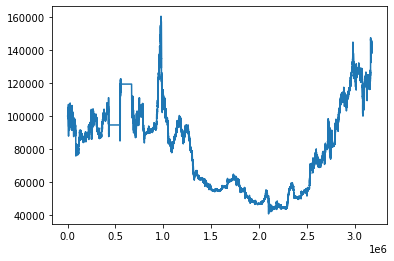

In [12]:
plt.plot(portfolio[0])
plt.show()